In [1]:
import os
import pandas as pd
import  datetime
import numpy as np
import matplotlib.pyplot as plt
import warnings; warnings.simplefilter('ignore')
%matplotlib inline


In [2]:
from bokeh.plotting import figure, output_file, show
from bokeh.io import output_notebook, show
from bokeh.plotting import figure
output_notebook()


Loading BokehJS ...

In [3]:
from bokeh.plotting import figure, output_file, show
from bokeh.models import ColumnDataSource
from bokeh.models.ranges import FactorRange
import pandas as pd

data = [
    ['201720', 'cat1', 20],
    ['201720', 'cat2', 30],
    ['201720', 'cat3', 40],
    ['201721', 'cat1', 20],
    ['201721', 'cat2', 0],
    ['201721', 'cat3', 40],
    ['201722', 'cat1', 50],
    ['201722', 'cat2', 60],
    ['201722', 'cat3', 10],
]

df = pd.DataFrame(data, columns=['week', 'category', 'count'])

pt = df.pivot('week', 'category', 'count')

pt = pt.cumsum(axis=1)

output_file("lines.html", title='Dashboard')

p = figure(title="count",
           x_axis_label='week', y_axis_label='category',
           x_range = FactorRange(factors=list(pt.index)),
           plot_height=300, plot_width=500)

p.vbar(x=pt.index, bottom=0, top=pt.cat1, width=0.2, color='red', legend='cat1')
p.vbar(x=pt.index, bottom=pt.cat1, top=pt.cat2, width=0.2, color='blue', legend='cat2')
p.vbar(x=pt.index, bottom=pt.cat2, top=pt.cat3, width=0.2, color='green', legend='cat3')


show(p)

https://benalexkeen.com/resampling-time-series-data-with-pandas/

In [4]:
data=pd.read_json('/Users/yangx/Downloads/ultimate_challenge/logins.json')

In [5]:
data.sort_values(by='login_time').head()

,login_time
6,1970-01-01 20:12:16
0,1970-01-01 20:13:18
1,1970-01-01 20:16:10
3,1970-01-01 20:16:36
2,1970-01-01 20:16:37


## Part 1 ‐ Exploratory data analysis

The attached logins.json file contains (simulated) timestamps of user logins in a particular geographic location. Aggregate these login counts based on 15minute time intervals, and visualize and describe the resulting time series of login counts in ways that best characterize the underlying patterns of the demand. Please report/illustrate important features of the demand, such as daily cycles. If there are data quality issues, please report them.

### aggregation at 15 min interval

In [6]:
df1=data.resample('15 min', on='login_time').count()
df1.index.name ='login_timestamp'
df1.reset_index(inplace=True)
df1.rename(columns={'login_time':'interval_15min_cnt'}, inplace=True)
df1.head()

,login_timestamp,interval_15min_cnt
0,1970-01-01 20:00:00,2
1,1970-01-01 20:15:00,6
2,1970-01-01 20:30:00,9
3,1970-01-01 20:45:00,7
4,1970-01-01 21:00:00,1


In [7]:
df1.login_timestamp.min(), df1.login_timestamp.max()

(Timestamp('1970-01-01 20:00:00'), Timestamp('1970-04-13 18:45:00'))

In [8]:
df1['hour']=df1.login_timestamp.dt.hour
df1['am_pm']=df1['hour'].apply(lambda x: 'AM' if x in range(0,12) else 'PM')
df1['dayofweek']=df1.login_timestamp.dt.dayofweek
df1['day_week']=df1.login_timestamp.dt.day_name()
df1['day']=df1.login_timestamp.dt.day
df1['month']=df1.login_timestamp.dt.month
df1.head()


,login_timestamp,interval_15min_cnt,hour,am_pm,dayofweek,day_week,day,month
0,1970-01-01 20:00:00,2,20,PM,3,Thursday,1,1
1,1970-01-01 20:15:00,6,20,PM,3,Thursday,1,1
2,1970-01-01 20:30:00,9,20,PM,3,Thursday,1,1
3,1970-01-01 20:45:00,7,20,PM,3,Thursday,1,1
4,1970-01-01 21:00:00,1,21,PM,3,Thursday,1,1


In [9]:
d={'interval_15min_cnt':'inval_sum'}
g=df1.groupby(['hour','day_week']).agg({'interval_15min_cnt':'sum'}).rename(columns=d).reset_index()
g=g.groupby('day_week').agg({'inval_sum':'mean'}).reset_index()
p = figure(title="day of week demand trending", plot_height=250, toolbar_location=None
           ,x_range=g.day_week.unique().tolist()
          )

p.vbar(x=g.day_week.unique().tolist(), top=g.inval_sum, width=0.9)
p.xgrid.grid_line_color = None
p.y_range.start = 0
show(p)


Total demand on weekends is larger than weekdays.

In [10]:
from bokeh.core.properties import value
from bokeh.transform import dodge, factor_cmap
from bokeh.models import CategoricalColorMapper, ColumnDataSource, FactorRange
from bokeh.plotting import figure

d={'interval_15min_cnt':'inval_sum'}
g=df1.groupby(['hour','day_week','am_pm']).agg({'interval_15min_cnt':'sum'}).rename(columns=d).reset_index()
g=g.groupby(['day_week','am_pm']).agg({'inval_sum':'mean'}).reset_index()
data = {'day_week' : g.loc[g.am_pm=='PM', ['day_week']]['day_week'].tolist(),
        'PM'   : g.loc[g.am_pm=='PM', ['inval_sum']]['inval_sum'].tolist(),
        'AM'   : g.loc[g.am_pm=='AM', ['inval_sum']]['inval_sum'].tolist()}

print(g)
source = ColumnDataSource(data=data)

p = figure(x_range=g.loc[g.am_pm=='PM', ['day_week']]['day_week'].tolist(), plot_height=400,
    toolbar_location=None, title="Demand by AM/PM")

p.vbar_stack(['AM','PM'], x='day_week', width=0.9, color=["blue", "orange"], source=source 
#              ,legend=['AM','PM']
            )

p.x_range.range_padding = 0.1
p.xgrid.grid_line_color = None
p.y_range.start = 0
# p.legend.location = "top_left"
# p.legend.orientation = "horizontal"
p.axis.minor_tick_line_color = None
p.outline_line_color = None
show(p)

     day_week am_pm   inval_sum
0      Friday    AM  493.666667
1      Friday    PM  773.666667
2      Monday    AM  325.416667
3      Monday    PM  409.833333
4    Saturday    AM  851.416667
5    Saturday    PM  763.333333
6      Sunday    AM  862.583333
7      Sunday    PM  651.333333
8    Thursday    AM  429.416667
9    Thursday    PM  567.250000
10    Tuesday    AM  330.083333
11    Tuesday    PM  442.250000
12  Wednesday    AM  380.833333
13  Wednesday    PM  480.750000


orange bar shows the PM demand while blue bar shows the AM demand.
Though the previous plot shows that total demand on weekends is larger than weekdays,PM demand is higher during the weekday than weekend.

In [11]:
d={'interval_15min_cnt':'inval_sum'}
g=df1.groupby('hour').agg({'interval_15min_cnt':'mean'}).rename(columns=d).reset_index()
p = figure(title="hourly demand trending", x_axis_label='hour', y_axis_label='inval_sum'
#            ,x_axis_type='datetime'
          )

# add a line renderer with legend and line thickness
p.line(g.hour,g.inval_sum)

# show the results
show(p)

In [12]:
df1.day_week.unique()

array(['Thursday', 'Friday', 'Saturday', 'Sunday', 'Monday', 'Tuesday',
       'Wednesday'], dtype=object)

In [13]:
d={'interval_15min_cnt':'inval_sum'}
df2=df1[df1.day_week.isin(['Saturday', 'Sunday'])]
g=df2.groupby('hour').agg({'interval_15min_cnt':'mean'}).rename(columns=d).reset_index()
p = figure(title="hourly demand trending during weekends", x_axis_label='hour', y_axis_label='inval_sum'
#            ,x_axis_type='datetime'
          )

# add a line renderer with legend and line thickness
p.line(g.hour,g.inval_sum)

# show the results
show(p)

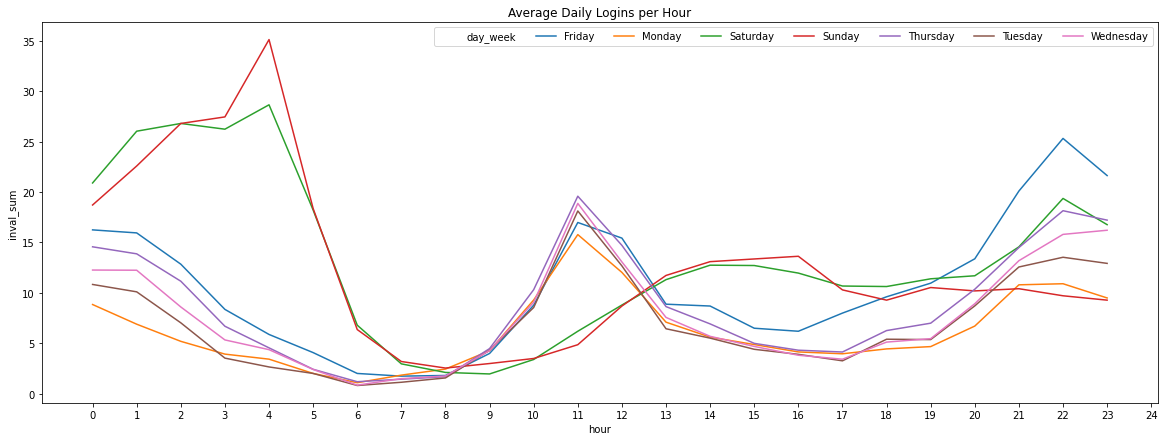

In [14]:

import matplotlib.pyplot as plt
import seaborn as sns

#getting average daily logins per hour
d={'interval_15min_cnt':'inval_sum'}
df_total = df1.groupby(["hour", "day_week"]).mean().rename(columns=d).reset_index()

#plotting df
f, axes = plt.subplots(figsize=(20,7))
ax = sns.lineplot(x="hour", y="inval_sum", data=df_total, hue="day_week")
ax.legend(loc="upper right", ncol=8)
ax.set(title="Average Daily Logins per Hour")
plt.xticks(range(0,25))

#display plot
plt.show()

As we can see the Sunday and Saturday trending is very different comparing to weekdays.
Weekends has a significant high demand peak around early morning time around 4am and then a small peak around 4pm in the afternoon.
While weekdays have two smaller peaks around 11 am and 11pm

In [15]:
d={'interval_15min_cnt':'inval_sum'}
df2=df1[~df1.day_week.isin(['Saturday', 'Sunday'])]
g=df2.groupby('hour').agg({'interval_15min_cnt':'mean'}).rename(columns=d).reset_index()
p = figure(title="hourly demand trending during weekdays", x_axis_label='hour', y_axis_label='inval_sum'
#            ,x_axis_type='datetime'
          )

# add a line renderer with legend and line thickness
p.line(g.hour,g.inval_sum)

# show the results
show(p)

In [16]:
d={'interval_15min_cnt':'inval_sum'}
g=df1.groupby(['hour','day']).agg({'interval_15min_cnt':'sum'}).rename(columns=d).reset_index()
g=g.groupby(['day']).agg({'inval_sum':'mean'}).reset_index()
p = figure(title="day of demand trending", x_axis_label='day', y_axis_label='inval_sum'
#            ,x_axis_type='datetime'
          )

# add a line renderer with legend and line thickness
p.line(g.day,g.inval_sum)

# show the results
show(p)

In [17]:
d={'interval_15min_cnt':'inval_sum'}
g=df1.groupby(['hour','day','month']).agg({'interval_15min_cnt':'sum'}).rename(columns=d).reset_index()
g=g.groupby(['day','month']).agg({'inval_sum':'sum'}).reset_index()
g=g.groupby(['month']).agg({'inval_sum':'mean'}).reset_index()
p = figure(title="monthly demand trending", x_axis_label='month', y_axis_label='inval_sum'
#            ,x_axis_type='datetime'
          )

# add a line renderer with legend and line thickness
p.line(g.month,g.inval_sum)

# show the results
show(p)

Business has a very stable growh since Jan. But the demand started going down since March. Maybe less acquisition effort or just a seasonal cycle; or there is a retention problem to the business

Aggregate these login counts based on 15minute time intervals, and visualize and describe the resulting time series of login counts in ways that best characterize the underlying patterns of the demand. Please report/illustrate important features of the demand, such as daily cycles. If there are data quality issues, please report them.

## Part 2 ‐ Experiment and metrics design
The neighboring cities of Gotham and Metropolis have complementary circadian rhythms: on weekdays, Ultimate Gotham is most active at night, and Ultimate Metropolis is most active during the day. On weekends, there is reasonable activity in both cities.
However, a toll bridge, with a two-way toll, between the two cities causes driver partners to tend to be exclusive to each city. The Ultimate managers of city operations for the two cities have proposed an experiment to encourage driver partners to be available in both cities, by reimbursing all toll costs.

1. What would you choose as the key measure of success of this experiment in encouraging driver partners to serve both cities, and why would you choose this metric?
2. Describe a practical experiment you would design to compare the effectiveness of the proposed change in relation to the key measure of success. Please provide details on:

a. how you will implement the experiment

b. what statistical test(s) you will conduct to verify the significance of the
observation

c. how you would interpret the results and provide recommendations to the city
operations team along with any caveats.


#### It would be two different kinds of cases based drivers types:
    1. User drivers 
    2. Taxi drivers

#### Uber style

1. Key measurement: number of times a driver crosses the toll bridge per day during the trip (serving the passengers) and non-trip as well.
2. Assuming it's possible to conduct a fair randomized controlled trial by using stratified resampling. 
- First,calculate a sample size by pre-define significant level (saying 90%) with minimal lift that meeting business needs.
- Second, get a control and test group by stratified resampling based on the drivers information we have.
- Third, get Length of the experiment

Then rolled out experiment and using t-test to verify whether to reject null hypthosis or not. 

a. 
- In the first 3 days, collect data and run sanity check to ensure stratified resampling work. So we would expect the metrics are very close in both groups.
- After passing the sanity check, experiment starts.

b. 
- It would be a two-sample T-test.

c. 
- If it achieves statitical significant means we reject null hythoesis and the reimbursement toll fee helps drivers serve both cities. However, there is still 10% chance that this result doesn't hold. 
- Assume, we observe numbers of times a driver crossing the toll bridge increased both non-trip and trip increased. Then we know that drivers themselves and their passengers benefit from this business idea.
- But if only numbers of times a driver crossing the toll bridge increased both non-trip increased. Then we know that this business idea doesn't stimulate drivers to carry trips between two cities.

- If it fails to achieves statitical significant means we fail to reject the reimbursement toll fee helps drivers serve both cities.





Taxi driver style

1. Key measurement: average counts of serves both cities per week per user
2. Assuming it's possible to conduct a fair randomized controlled trial by using stratified resampling. 
- First,calculate a sample size by pre-define significant level (saying 90%) with minimal lift that meeting business needs.
- Second, get a control and test group by stratified resampling based on the drivers information we have.
- Third, get Length of the experiment

Then rolled out experiment and using t-test to verify whether to reject null hypthosis or not. 

a. 
- In the first week, collect data and run sanity check to ensure stratified resampling work. So we would expect the metrics are very close in both groups.
- After passing the sanity check, experiment starts.

b. 
- It would be a two-sample T-test.

c. 
- If it achieves statitical significant means we reject null hythoesis and the reimbursement toll fee helps drivers serve both cities. However, there is still 10% chance that this result doesn't hold. 

- If it fails to achieves statitical significant means we fail to reject the reimbursement toll fee helps drivers serve both cities.


   



## Part 3 ‐ Predictive modeling
Ultimate is interested in predicting rider retention. To help explore this question, we have provided a sample dataset of a cohort of users who signed up for an Ultimate account in January 2014. The data was pulled several months later; we consider a user retained if they were “active” (i.e. took a trip) in the preceding 30 days.

We would like you to use this data set to help understand **what factors are the best predictors for retention**, and offer suggestions to operationalize those insights to help Ultimate.

The data is in the attached file ultimate_data_challenge.json. See below for a detailed description of the dataset. Please include any code you wrote for the analysis and delete the dataset when you have finished with the challenge.

1. Perform any cleaning, exploratory analysis, and/or visualizations to use the provided data for this analysis (a few sentences/plots describing your approach will suffice). What fraction of the observed users were retained?

**Ans:**
Based on the definion of active users, let's assume that last_active_date - signup_date > 150 days means active users. 
So that we have 74.5% of active users.


2. Build a predictive model to help Ultimate determine **whether or not a user will be active in their 6th month on the system**. Discuss why you chose your approach, what alternatives you considered, and any concerns you have. How valid is your model? Include any key indicators of model performance.

**Ans:**
- F1 score is chosen to evaluate model performance since the data is imbalanced
- From calculating and plotting feaure importance, we've learnt that 

(1) the signup weekday is almost not important at all comparing with other variables. 

(2)  avg_rating_by_driver looks like a very important variables with a high important score

- Signup weekday is not important to the business since both testing and train f1 score improved by re-run the model with removing this variable. So that business 

3. Briefly discuss how Ultimate might leverage the insights gained from the model to improve its long-term rider retention (again, a few sentences will suffice).

**Ans:**
1) increase marketing on company apps (if any) for iPhone users; it shows that iPhone users are more active than android users

2) Investigate and understand why some drivers has no avg_rating. Is that because of their are new drivers and no familiar with the service that they suppose to provide. So from here if majority of them are new drivers (maybe join the company less than 30 days or based on other definition which make sense to the business). It would be helpful to improve the retention rate if company could off some training to help new drivers warm-up faster. Another, maybe it causes by the guests. Maybe most of them are new app users and they don't know how to rating the driver or forgot to rate. The PM might want to create push notification to help users rate the driver especially for new users.

3) First 30days of the customer is critical on customer retention. Give discounts or promotions during the first 30days of sign-up.

4) So we could tell marketing teams that they don't need to run marketing campaigns to get people signup on specific day of week since day of week doesn't contribute to prediction.

Data description
- city: city this user signed up in
- phone: primary device for this user
- signup_date: date of account registration; in the form ‘YYYYMMDD’
- last_trip_date: the last time this user completed a trip; in the form ‘YYYYMMDD’
- avg_dist: the average distance in miles per trip taken in the first 30 days after signup
- avg_rating_by_driver: the rider’s average rating over all of their trips
- avg_rating_of_driver: the rider’s average rating of their drivers over all of their trips
- surge_pct: the percent of trips taken with surge multiplier > 1
- avg_surge: The average surge multiplier over all of this user’s trips
- trips_in_first_30_days: the number of trips this user took in the first 30 days after
signing up
- ultimate_black_user: TRUE if the user took an Ultimate Black in their first 30 days;
FALSE otherwise
- weekday_pct: the percent of the user’s trips occurring during a weekday

https://samperson1997.github.io/2018/06/03/classification-algorithm/

用于数据挖掘的分类算法有哪些，各有何优劣？
https://www.zhihu.com/question/24169940
https://developer.aliyun.com/article/67228
http://www.python88.com/topic/44663

dtree
https://mp.weixin.qq.com/s?__biz=MzUzMTEwODk0Ng==&mid=2247488089&idx=1&sn=6e9b01bd428761664f69d34c37e4d676&chksm=fa46d764cd315e7240c73e8d9b9df28008d83c698a05b1c40e234729bbd4fe0863c274ab5348&scene=21#wechat_redirect




- Recall measures the system’s ability to find all the relevant documents
- Precision measures the system’s ability to reject any nonrelevant documents in the retrieved set

A system can make two types of errors:

- a false positive error: the system retrieves a document that is non-relevant (should not have been retrieved)
- a false negative error: the system fails to retrieve adocument that is relevant (should have been retrieved)
- How do these types of errors affect precision and recall?
- Precision is affected by the number of false positive errors
- Recall is affected by the number of false negative errors

https://ils.unc.edu/courses/2013_spring/inls509_001/lectures/10-EvaluationMetrics.pdf

 ### Q1: Perform any cleaning, exploratory analysis, and/or visualizations to use the provided data for this analysis (a few sentences/plots describing your approach will suffice). What fraction of the observed users were retained?

Here retain means: user take at least one trip after signup date

In [18]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
import xgboost as xgb
from sklearn.svm import SVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score


In [19]:
df=pd.read_json('/Users/yangx/Downloads/ultimate_challenge/ultimate_data_challenge.json')
df.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9


In [20]:
df.city.unique()

array(["King's Landing", 'Astapor', 'Winterfell'], dtype=object)

In [21]:
df.shape

(50000, 12)

In [22]:
df.describe()

,trips_in_first_30_days,avg_rating_of_driver,avg_surge,surge_pct,weekday_pct,avg_dist,avg_rating_by_driver
count,50000.000000,41878.000000,50000.000000,50000.000000,50000.000000,50000.000000,49799.000000
mean,2.278200,4.601559,1.074764,8.849536,60.926084,5.796827,4.778158
std,3.792684,0.617338,0.222336,19.958811,37.081503,5.707357,0.446652
min,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000
25%,0.000000,4.300000,1.000000,0.000000,33.300000,2.420000,4.700000
50%,1.000000,4.900000,1.000000,0.000000,66.700000,3.880000,5.000000
75%,3.000000,5.000000,1.050000,8.600000,100.000000,6.940000,5.000000
max,125.000000,5.000000,8.000000,100.000000,100.000000,160.960000,5.000000


In [23]:
df.signup_date.min(), df.signup_date.max()

('2014-01-01', '2014-01-31')

In [24]:
df.last_trip_date.min(), df.last_trip_date.max()

('2014-01-01', '2014-07-01')

In [25]:
# from pandas_profiling import ProfileReport
# profile = ProfileReport(df, title="Pandas Profiling Report")

In [26]:
df.isnull().sum()

city                         0
trips_in_first_30_days       0
signup_date                  0
avg_rating_of_driver      8122
avg_surge                    0
last_trip_date               0
phone                      396
surge_pct                    0
ultimate_black_user          0
weekday_pct                  0
avg_dist                     0
avg_rating_by_driver       201
dtype: int64

#### What's the fraction of user taking at least one trip after signup VS 0 trip

In [27]:
#convert string to datetime
df['last_trip_date'] = pd.to_datetime(df['last_trip_date'])
df['signup_date']    = pd.to_datetime(df['signup_date'])
df['num_of_days_active'] = df['last_trip_date'] - df['signup_date'] 
#assign 1 if active, 0 if not active for past
df['active_user'] = df['num_of_days_active'].apply(lambda x: int(x >= pd.Timedelta('150 days')))
df.groupby('active_user').size()/len(df)


active_user
0    0.74572
1    0.25428
dtype: float64

In [28]:
df2=df[df.avg_rating_of_driver.isnull()]
df2.groupby('active_user').size()/len(df)

active_user
0    0.14418
1    0.01826
dtype: float64

In [29]:
df3=df[df.avg_rating_by_driver.isnull()]
df3.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,num_of_days_active,active_user
90,Winterfell,1,2014-01-10,5.0,1.0,2014-02-09,iPhone,0.0,False,0.0,6.28,NaN,30 days,0
274,Astapor,1,2014-01-25,2.0,4.0,2014-02-09,iPhone,100.0,False,0.0,6.00,NaN,15 days,0
277,Winterfell,1,2014-01-25,NaN,1.0,2014-01-26,iPhone,0.0,False,0.0,1.82,NaN,1 days,0
536,Winterfell,1,2014-01-18,5.0,1.0,2014-02-08,Android,0.0,False,100.0,1.41,NaN,21 days,0
857,Winterfell,0,2014-01-11,4.0,1.0,2014-03-16,iPhone,0.0,False,0.0,0.42,NaN,64 days,0


1. break down by city/devices/ultimate_black_user
2. correlation: all numberic numbers with fraction
- avg ratings
- avg_surge
- avg_dist
- weekday_pct

### Q2 Build a predictive model to help Ultimate determine whether or not a user will be active in their 6th month on the system. Discuss why you chose your approach, what alternatives you considered, and any concerns you have. How valid is your model? Include any key indicators of model performance.

In [30]:
# feature engineering
df.isnull().sum()/len(df)

city                      0.00000
trips_in_first_30_days    0.00000
signup_date               0.00000
avg_rating_of_driver      0.16244
avg_surge                 0.00000
last_trip_date            0.00000
phone                     0.00792
surge_pct                 0.00000
ultimate_black_user       0.00000
weekday_pct               0.00000
avg_dist                  0.00000
avg_rating_by_driver      0.00402
num_of_days_active        0.00000
active_user               0.00000
dtype: float64

In [31]:
# feature engineering - missing date

# phone
df["phone"].fillna("Unknown", inplace = True) 

# drop other missing values and we still have 83% of the data set
dff=df.dropna()

In [32]:
# add variable
dff['signup_wk_name']=dff['signup_date'].dt.day_name()


In [33]:
# create dummy variabes for low cadinality variables
cols_to_drop=['num_of_days_active','signup_date','last_trip_date']
dff.drop(columns=cols_to_drop, inplace=True)

In [34]:
dff.head(2)

,city,trips_in_first_30_days,avg_rating_of_driver,avg_surge,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,active_user,signup_wk_name
0,King's Landing,4,4.7,1.1,iPhone,15.4,True,46.2,3.67,5.0,0,Saturday
1,Astapor,0,5.0,1.0,Android,0.0,False,50.0,8.26,5.0,0,Wednesday


## Create test and train datasets

In [35]:
train=dff.drop(columns=['active_user'])
y = dff['active_user']
train_ext = pd.get_dummies(train, columns=['city','phone','signup_wk_name'])

In [36]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(train_ext, y, random_state=42)

### Let try the randomforest classifier first and check feature importance

In [37]:
from sklearn import metrics
rf=RandomForestClassifier(n_estimators=80, max_depth = 5)
rf.fit(X_train,y_train)
y_pred=rf.predict(X_test)
y_pred2=rf.predict(X_train)

In [38]:
print("training f1 score:",metrics.f1_score(y_train, y_pred2))

training f1 score: 0.47200765099683656


In [39]:
print("testing f1 score:",metrics.f1_score(y_test, y_pred))

testing f1 score: 0.47795722391968576


In [40]:
# out put feature importance
import pandas as pd
feature_imp = pd.Series(rf.feature_importances_,index=X_train.columns).sort_values(ascending=False)
feature_imp

avg_rating_by_driver        0.223457
surge_pct                   0.202930
avg_surge                   0.132688
weekday_pct                 0.101598
city_King's Landing         0.076405
phone_iPhone                0.054660
phone_Android               0.051981
trips_in_first_30_days      0.046167
ultimate_black_user         0.037878
avg_rating_of_driver        0.025170
city_Astapor                0.024846
avg_dist                    0.010533
city_Winterfell             0.007163
signup_wk_name_Friday       0.001738
signup_wk_name_Saturday     0.000648
signup_wk_name_Monday       0.000577
signup_wk_name_Wednesday    0.000500
signup_wk_name_Sunday       0.000330
signup_wk_name_Tuesday      0.000310
signup_wk_name_Thursday     0.000213
phone_Unknown               0.000209
dtype: float64

No handles with labels found to put in legend.


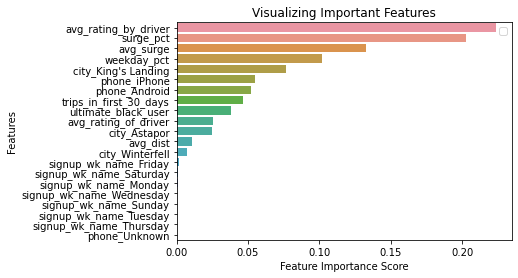

In [41]:
#plot feature importance
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
# Creating a bar plot
sns.barplot(x=feature_imp, y=feature_imp.index)
# Add labels to your graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.legend()
plt.show()

insights from the plot:

- From the plot, it seems that signup weekday is almost not important at all comparing with other variables. 
- avg_rating_by_driver looks like a very important variables with a high important score

**This tells use that null values of avg_rating_by_drivers shouldn't be dropped off. As we've learnt from the EDA that the majority of the inactive user with null value in avg_rating_by_drivers. So we should input this information (instead of del them) into the model. And see it it helps the model to increase the performance**



### Run RF again without signup_wk variables
From the plot,it shows that signup weekday is almost not important at all comparing with other variables.
However, they increased the dimensionality when input them into the model. This might cause overfitting as well. 
So let's try without signup_wk variables

In [42]:
X_train.columns

Index(['trips_in_first_30_days', 'avg_rating_of_driver', 'avg_surge',
       'surge_pct', 'ultimate_black_user', 'weekday_pct', 'avg_dist',
       'avg_rating_by_driver', 'city_Astapor', 'city_King's Landing',
       'city_Winterfell', 'phone_Android', 'phone_Unknown', 'phone_iPhone',
       'signup_wk_name_Friday', 'signup_wk_name_Monday',
       'signup_wk_name_Saturday', 'signup_wk_name_Sunday',
       'signup_wk_name_Thursday', 'signup_wk_name_Tuesday',
       'signup_wk_name_Wednesday'],
      dtype='object')

In [43]:
cols_to_drop=['signup_wk_name_Friday','signup_wk_name_Monday','signup_wk_name_Saturday','signup_wk_name_Sunday'
              ,'signup_wk_name_Thursday','signup_wk_name_Tuesday','signup_wk_name_Wednesday']
X_train.drop(columns=cols_to_drop, inplace=True)
X_test.drop(columns=cols_to_drop, inplace=True)

In [44]:
from sklearn import metrics
rf=RandomForestClassifier(n_estimators=80, max_depth = 5)
rf.fit(X_train,y_train)
y_pred=rf.predict(X_test)
y_pred2=rf.predict(X_train)

In [45]:
print("training f1 score:",metrics.f1_score(y_train, y_pred2))
print("testing f1 score:",metrics.f1_score(y_test, y_pred))

training f1 score: 0.4750618002035772
testing f1 score: 0.48126489062161576


#### Good news: both training and testing f1 scores increased
So we could tell marketing teams that they don't need to run marketing campaigns to get people signup on specific day of week since day of week doesn't contribute to prediction.

In [46]:
# out put feature importance
import pandas as pd
feature_imp = pd.Series(rf.feature_importances_,index=X_train.columns).sort_values(ascending=False)
feature_imp

surge_pct                 0.213688
avg_rating_by_driver      0.211832
avg_surge                 0.143954
weekday_pct               0.081399
city_King's Landing       0.071909
phone_iPhone              0.056115
phone_Android             0.053558
trips_in_first_30_days    0.046005
ultimate_black_user       0.043599
avg_rating_of_driver      0.043534
city_Astapor              0.022649
avg_dist                  0.006153
city_Winterfell           0.005503
phone_Unknown             0.000102
dtype: float64

No handles with labels found to put in legend.


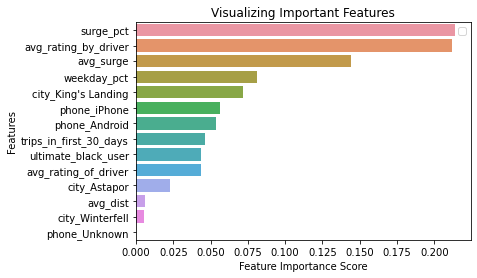

In [47]:
#plot feature importance
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
# Creating a bar plot
sns.barplot(x=feature_imp, y=feature_imp.index)
# Add labels to your graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.legend()
plt.show()

# So the next steps are:
1. Try different models
2. Hyperparameter tuning
3. CV to get the best avg f1 score for each model
4. Select the best model